In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from selenobot.files import XMLFile
from selenobot.utils import seed 
from selenobot.datasets import Dataset, get_dataloader
from selenobot.utils import digitize, groupby, sample
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from tqdm import tqdm
from scipy.stats import false_discovery_control, mannwhitneyu

import warnings 
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

colors = {1:'tab:red', 2:'tab:blue', 0:'gray'}
plt.rcParams['font.family'] = 'Arial'


In [ ]:
Dataset.from_hdf('../data/train.h5', feature_type='plm_esm')

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
A0A009IHW8,-0.507742,-0.434003,0.615265,0.386498,-0.502668,-0.642833,-0.139074,0.113050,0.068611,-0.301400,...,-0.155810,0.283580,-0.416844,-0.004932,-0.180294,0.119787,0.294159,-0.129948,0.525420,0.567322
A0A010YS46-,-0.475144,-0.429542,0.596167,0.363728,-0.495078,-0.647179,-0.139627,0.079515,0.014839,-0.264026,...,-0.076769,0.195300,-0.458379,0.048172,-0.169985,0.146734,0.387659,-0.123830,0.496201,0.531999
A0A011QK89,-0.500738,-0.392732,0.602199,0.291563,-0.491665,-0.643342,-0.164162,0.091227,0.050273,-0.247680,...,-0.105574,0.129133,-0.430895,0.018135,-0.220122,0.114714,0.324742,-0.122721,0.525514,0.534585
A0A023GPJ0,-0.503396,-0.422526,0.638906,0.333640,-0.491324,-0.634774,-0.114437,0.038044,0.075798,-0.268847,...,-0.094246,0.190054,-0.468822,0.069047,-0.164935,0.155811,0.357195,-0.189902,0.489112,0.518966
A0A023W421,-0.511284,-0.410956,0.642076,0.352987,-0.495290,-0.641441,-0.112673,0.041534,0.048515,-0.262209,...,-0.054239,0.149596,-0.410990,-0.005203,-0.209563,0.195975,0.340859,-0.151834,0.510372,0.526684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W8X5L3,-0.476176,-0.392116,0.635222,0.305094,-0.468855,-0.627601,-0.184622,0.106083,0.085003,-0.268795,...,-0.112998,0.139606,-0.449544,0.069003,-0.203919,0.162469,0.365805,-0.140385,0.543405,0.549757
W8X9R5,-0.488461,-0.385515,0.634281,0.314692,-0.516000,-0.629831,-0.146379,0.080353,0.044230,-0.246533,...,-0.129720,0.168563,-0.418903,0.024163,-0.196276,0.112175,0.350054,-0.143269,0.516701,0.533191
X5CFH4,-0.477830,-0.378623,0.624126,0.294876,-0.491832,-0.621032,-0.171497,0.117197,0.072733,-0.261116,...,-0.113452,0.136968,-0.444544,0.060875,-0.187273,0.161821,0.343009,-0.139022,0.558084,0.547205
X5CWH9,-0.487854,-0.390943,0.630304,0.309009,-0.483014,-0.627086,-0.155019,0.110694,0.085056,-0.264832,...,-0.096417,0.155474,-0.445547,0.062512,-0.189004,0.154572,0.347158,-0.142766,0.564639,0.548436


In [6]:
pd.read_hdf('../data/val.h5', key='plm_esm')

,0,1,2,3,4,5,6,7,8,9,...,2550,2551,2552,2553,2554,2555,2556,2557,2558,2559
A0A010YTV1-,0.187046,-0.174376,0.553128,0.373365,0.104089,-0.118329,0.544169,-0.594637,0.083830,0.374218,...,0.114741,-0.216878,0.389942,0.060528,0.230066,-0.401406,0.524395,-0.231213,-0.000300,-0.279419
A0A059ZV61,0.210209,-0.217971,0.519885,0.390280,0.125647,-0.140993,0.545670,-0.589093,0.081614,0.357560,...,0.115273,-0.185722,0.348360,0.104681,0.271016,-0.381869,0.548346,-0.226999,-0.001345,-0.291742
A0A069RDY6-,0.191227,-0.183807,0.533500,0.396881,0.156414,-0.129280,0.544031,-0.595628,0.059443,0.345486,...,0.089123,-0.159343,0.381770,0.086770,0.248242,-0.367044,0.535073,-0.227028,0.023214,-0.321019
A0A098B5S9-,0.190880,-0.158860,0.538482,0.440329,0.106601,-0.113807,0.533910,-0.572863,0.091930,0.368169,...,0.117904,-0.208454,0.408725,0.056701,0.250173,-0.406673,0.533556,-0.227773,-0.004585,-0.259040
A0A0A1DMJ6-,0.218174,-0.173323,0.550164,0.417155,0.123778,-0.137944,0.543136,-0.574138,0.070739,0.356669,...,0.143207,-0.209521,0.377351,0.042415,0.229942,-0.400079,0.546054,-0.224918,0.018573,-0.233434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V6F5E5,0.224966,-0.181475,0.532992,0.402882,0.105026,-0.145742,0.540929,-0.582025,0.033935,0.347777,...,0.159500,-0.167090,0.408505,0.042211,0.242838,-0.438797,0.502945,-0.264359,0.002754,-0.293666
W0W999,0.191438,-0.202006,0.528897,0.377181,0.126102,-0.098139,0.571472,-0.598781,0.035623,0.381835,...,0.102985,-0.194297,0.379938,0.049902,0.248033,-0.401480,0.525586,-0.243689,0.033340,-0.268386
W8JNL4,0.192108,-0.197224,0.526239,0.375042,0.131292,-0.103838,0.568775,-0.596011,0.046196,0.374951,...,0.097613,-0.199138,0.386166,0.043064,0.243315,-0.410369,0.522366,-0.251358,0.019823,-0.284108
W8TJT0-,0.157425,-0.185666,0.550406,0.370280,0.169247,-0.109873,0.553770,-0.627153,0.042954,0.368371,...,0.144996,-0.200495,0.421602,0.084914,0.205452,-0.397485,0.566204,-0.202854,0.005244,-0.317936


In [3]:
def plot_length_distribution(metadata_dfs:List[pd.DataFrame], ax:plt.Axes=None, bins:int=25, density:bool=False):

    n_dropped, lengths = 0, []
    for df in metadata_dfs:
        nans = df.seq.isnull()
        n_dropped += nans.sum()
        lengths.append(df[~nans].seq.apply(len).values)
    print(f'plot_length_distribution: Dropped {n_dropped} empty sequences.')

    ax.hist(lengths, density=density, bins=bins, edgecolor='white')
    ax.set_ylabel('density' if density else 'count')
    ax.set_xlabel('length')


In [4]:
train_metadata_df = pd.read_csv('../data/train_metadata.csv', index_col=0)
test_metadata_df = pd.read_csv('../data/test_metadata.csv', index_col=0)
val_metadata_df = pd.read_csv('../data/val_metadata.csv', index_col=0)

metadata_df = pd.concat([train_metadata_df, test_metadata_df, val_metadata_df])
metadata_df = metadata_df[~metadata_df.seq.isnull()]

label_0_metadata_df = metadata_df[metadata_df.label == 0]
label_1_metadata_df = metadata_df[metadata_df.label == 1]
label_2_metadata_df = metadata_df[metadata_df.label == 2]

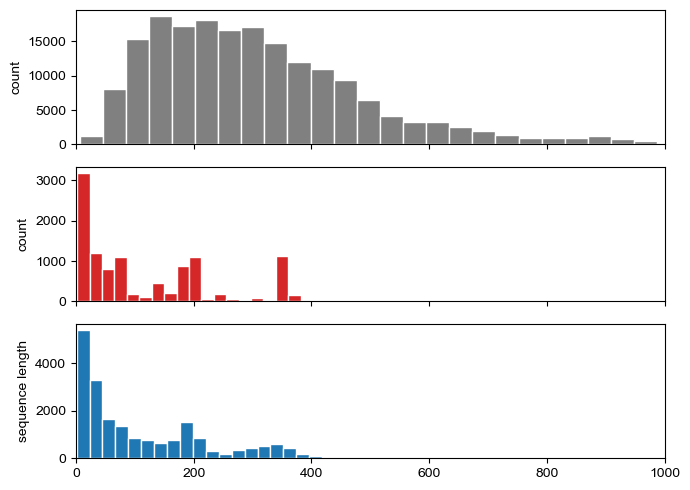

In [5]:
fig, axes = plt.subplots(figsize=(7, 5), nrows=3, sharex=True)

for label, ax in enumerate(axes):
    label_metadata_df = metadata_df[metadata_df.label == label]
    ax.hist(label_metadata_df.seq.apply(len), bins=50, color=colors[label], edgecolor='white')
    ax.set_ylabel('count')
    # ax.set_title(f'label {label} (n={len(label_metadata_df)})')
    ax.set_xlim(xmax=1000, xmin=0)

axes[-1].set_ylabel('sequence length')
plt.tight_layout()
plt.show()

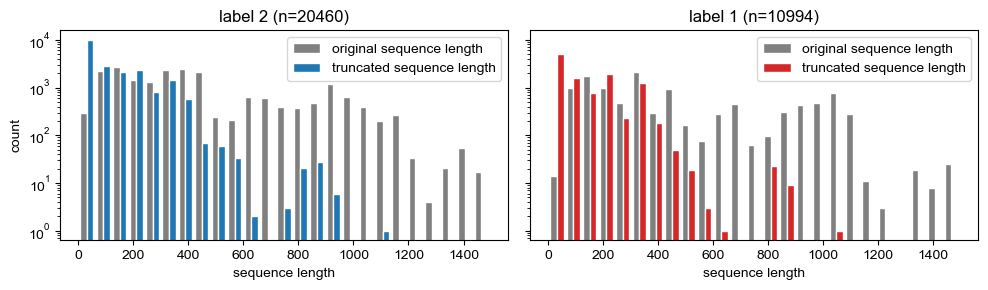

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3), sharey=True)

axes[0].hist((label_2_metadata_df.original_length, label_2_metadata_df.seq.apply(len)), bins=25, edgecolor='white', color=['gray', colors[2]])
axes[0].set_yscale('log')
axes[0].set_ylabel('count')
axes[0].set_xlabel('sequence length')
axes[0].legend(['original sequence length', 'truncated sequence length'])
axes[0].set_title(f'label 2 (n={len(label_2_metadata_df)})')

axes[1].hist((label_1_metadata_df.original_length, label_1_metadata_df.seq.apply(len)), bins=25, edgecolor='white', color=['gray', colors[1]])
axes[1].set_yscale('log')
# axes[1].set_ylabel('count')
axes[1].set_xlabel('sequence length')
axes[1].legend(['original sequence length', 'truncated sequence length'])
axes[1].set_title(f'label 1 (n={len(label_1_metadata_df)})')

plt.tight_layout()
plt.show()

In [31]:
metadata_binary_df = metadata_df.copy()[metadata_df.label.isin([0, 1])]

for level in ['phylum', 'class', 'order', 'family', 'species']:
    p = int(100 * (~metadata_binary_df[level].isnull()).sum() / len(metadata_binary_df))
    label_1_p = int(100 * (~label_1_metadata_df[level].isnull()).sum() / len(label_1_metadata_df)) 
    label_0_p = int(100 * (~label_0_metadata_df[level].isnull()).sum() / len(label_0_metadata_df)) 
    print(f'{p}% of the sequences have an assigned {level} ({label_1_p}% label 1, {label_0_p}% label 0).')

for level in ['phylum', 'class', 'order', 'family', 'species']:
    metadata_binary_df[level] = metadata_binary_df[level].fillna(f'no {level}')
    label_1_metadata_df[level] = label_1_metadata_df[level].fillna(f'no {level}')
    label_0_metadata_df[level] = label_0_metadata_df[level].fillna(f'no {level}')

98% of the sequences have an assigned phylum (74% label 1, 99% label 0).
97% of the sequences have an assigned class (56% label 1, 99% label 0).
97% of the sequences have an assigned order (50% label 1, 99% label 0).
94% of the sequences have an assigned family (35% label 1, 97% label 0).
100% of the sequences have an assigned species (100% label 1, 100% label 0).


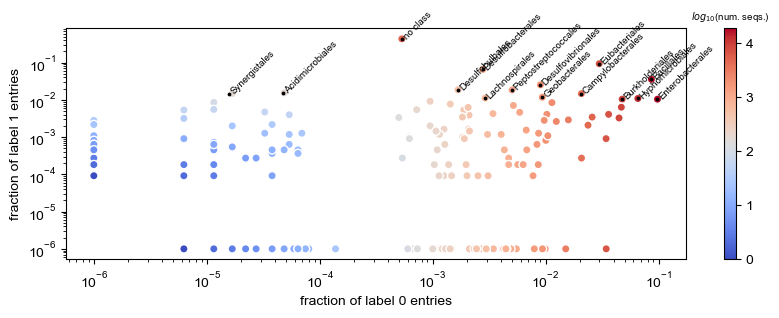

In [32]:
fig, ax = plt.subplots(figsize=(10, 3))

level = 'class'

n_label_0_per_phylum_df = pd.DataFrame(label_0_metadata_df.groupby(level).apply(len, include_groups=False), columns=['n_label_0'])
n_label_1_per_phylum_df = pd.DataFrame(label_1_metadata_df.groupby(level).apply(len, include_groups=False), columns=['n_label_1'])
df = n_label_0_per_phylum_df.merge(n_label_1_per_phylum_df, left_index=True, right_index=True, how='outer').fillna(0)
df['fraction_label_0']  = df.n_label_0 / df.n_label_0.sum()
df['fraction_label_1'] = df.n_label_1 / df.n_label_1.sum()
df['n_entries'] = df.n_label_0 + df.n_label_1
df['log10_n_entries'] = np.log10(df.n_entries)
cmap = plt.get_cmap('coolwarm')
df['color'] = [cmap(n / df.log10_n_entries.max()) for n in df.log10_n_entries]

ax.scatter(df.fraction_label_0 + 1e-6, df.fraction_label_1 + 1e-6, edgecolor='white', color=df.color) # Add small values so the zeros are included with log scale. 
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('fraction of label 1 entries')
ax.set_xlabel('fraction of label 0 entries')

norm = mpl.colors.Normalize(vmin=df.log10_n_entries.min(), vmax=df.log10_n_entries.max())
scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(scalar_mappable, ax=ax, cmap=cmap)
cbar.ax.set_title('$log_{10}$(num. seqs.)', fontsize='x-small')

for row in df.sort_values(by='fraction_label_1', ascending=False).iloc[:15].itertuples():
    x = row.fraction_label_0
    y = row.fraction_label_1
    ax.scatter([x], [y], color='black', s=3)
    ax.text(x, y, row.Index, fontsize='x-small', horizontalalignment='left', rotation=45)


plt.show()
